In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# 读取数据
data = pd.read_csv(r'D:\ArcgisData\pred_tl\pred_table\test\feature_table_result\feature_table_result.csv')

# 数据描述性统计
print(data.describe())

# 编码类别特征
categorical_columns = ['亚类', '土属', '土种', '土类']
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# 标准化数值特征
numerical_features = data.drop(columns=categorical_columns)
scaler = StandardScaler()
data[numerical_features.columns] = scaler.fit_transform(numerical_features)

# 选择重要的特征并创建交互特征
selected_features = ['PH', 'LAT', 'LON', 'SOM', 'TWI5', 'SLOP', 'TPI3', 'SC2', 'PRE']
for i in range(len(selected_features)):
    for j in range(i+1, len(selected_features)):
        feature_name = selected_features[i] + "_x_" + selected_features[j]
        data[feature_name] = data[selected_features[i]] * data[selected_features[j]]

# 划分训练集和测试集
X = data.drop(columns=categorical_columns)
y = data['土类']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用XGBoost模型
xgb_classifier = xgb.XGBClassifier(objective="multi:softprob", random_state=42, eval_metric="mlogloss")
cross_val_scores_xgb = cross_val_score(xgb_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("XGBoost交叉验证准确率:", np.mean(cross_val_scores_xgb))

# 超参数调优
param_grid_simple = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 7],
    'subsample': [0.7, 1.0]
}
grid_search_simple = GridSearchCV(xgb_classifier, param_grid_simple, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_simple.fit(X_train, y_train)
print("最佳超参数:", grid_search_simple.best_params_)
print("最佳交叉验证准确率:", grid_search_simple.best_score_)


              TWI5       TPI201       TPI101        TPI11         TPI3  \
count  2274.000000  2274.000000  2274.000000  2274.000000  2274.000000   
mean      6.058731   -18.020176   -12.553620    -0.580226    -0.046171   
std       2.154841    37.800043    22.541314     2.356788     0.226745   
min       1.581334  -302.742000  -246.835750   -64.331790    -5.984253   
25%       4.619825   -40.382935   -25.877624    -1.170990    -0.088913   
50%       5.663945   -16.615753   -11.124847    -0.295471    -0.021027   
75%       7.087224     4.930542     0.543152     0.303635     0.024765   
max      16.658188   121.780150    62.331177     8.372437     0.767944   

               TMP       SOILQS         SLOP          PRE        NIGTH  ...  \
count  2274.000000  2274.000000  2274.000000  2274.000000  2274.000000  ...   
mean    146.143396    11.418646    16.302502   844.404245     0.354371  ...   
std      12.897502     0.687213    11.179162    25.944639     0.597315  ...   
min     115.08333

d:\worker_code\.venvgis\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\worker_code\.venvgis\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\worker_code\.venvgis\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\worker_code\.venvgis\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\worker_code\.venvgis\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from current font.
  fig.canvas.print_figure(bytes_io, *

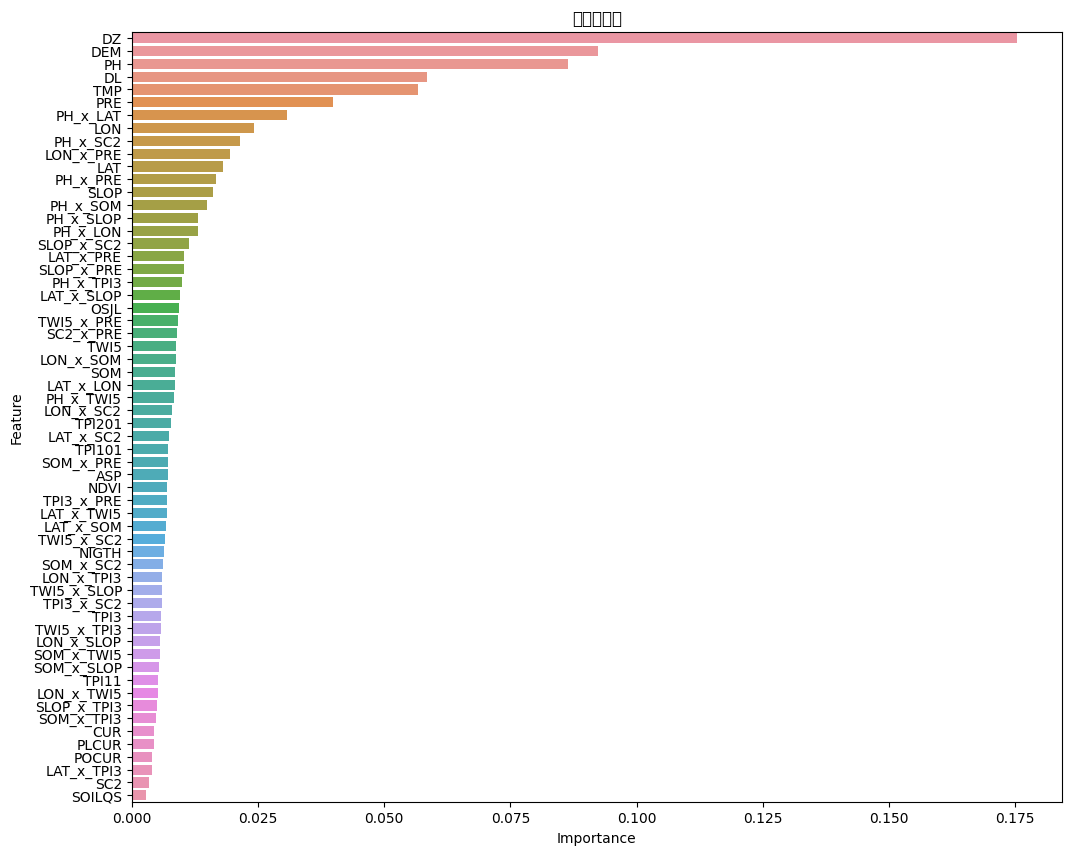

d:\worker_code\.venvgis\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\worker_code\.venvgis\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\worker_code\.venvgis\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30697 (\N{CJK UNIFIED IDEOGRAPH-77E9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\worker_code\.venvgis\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38453 (\N{CJK UNIFIED IDEOGRAPH-9635}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


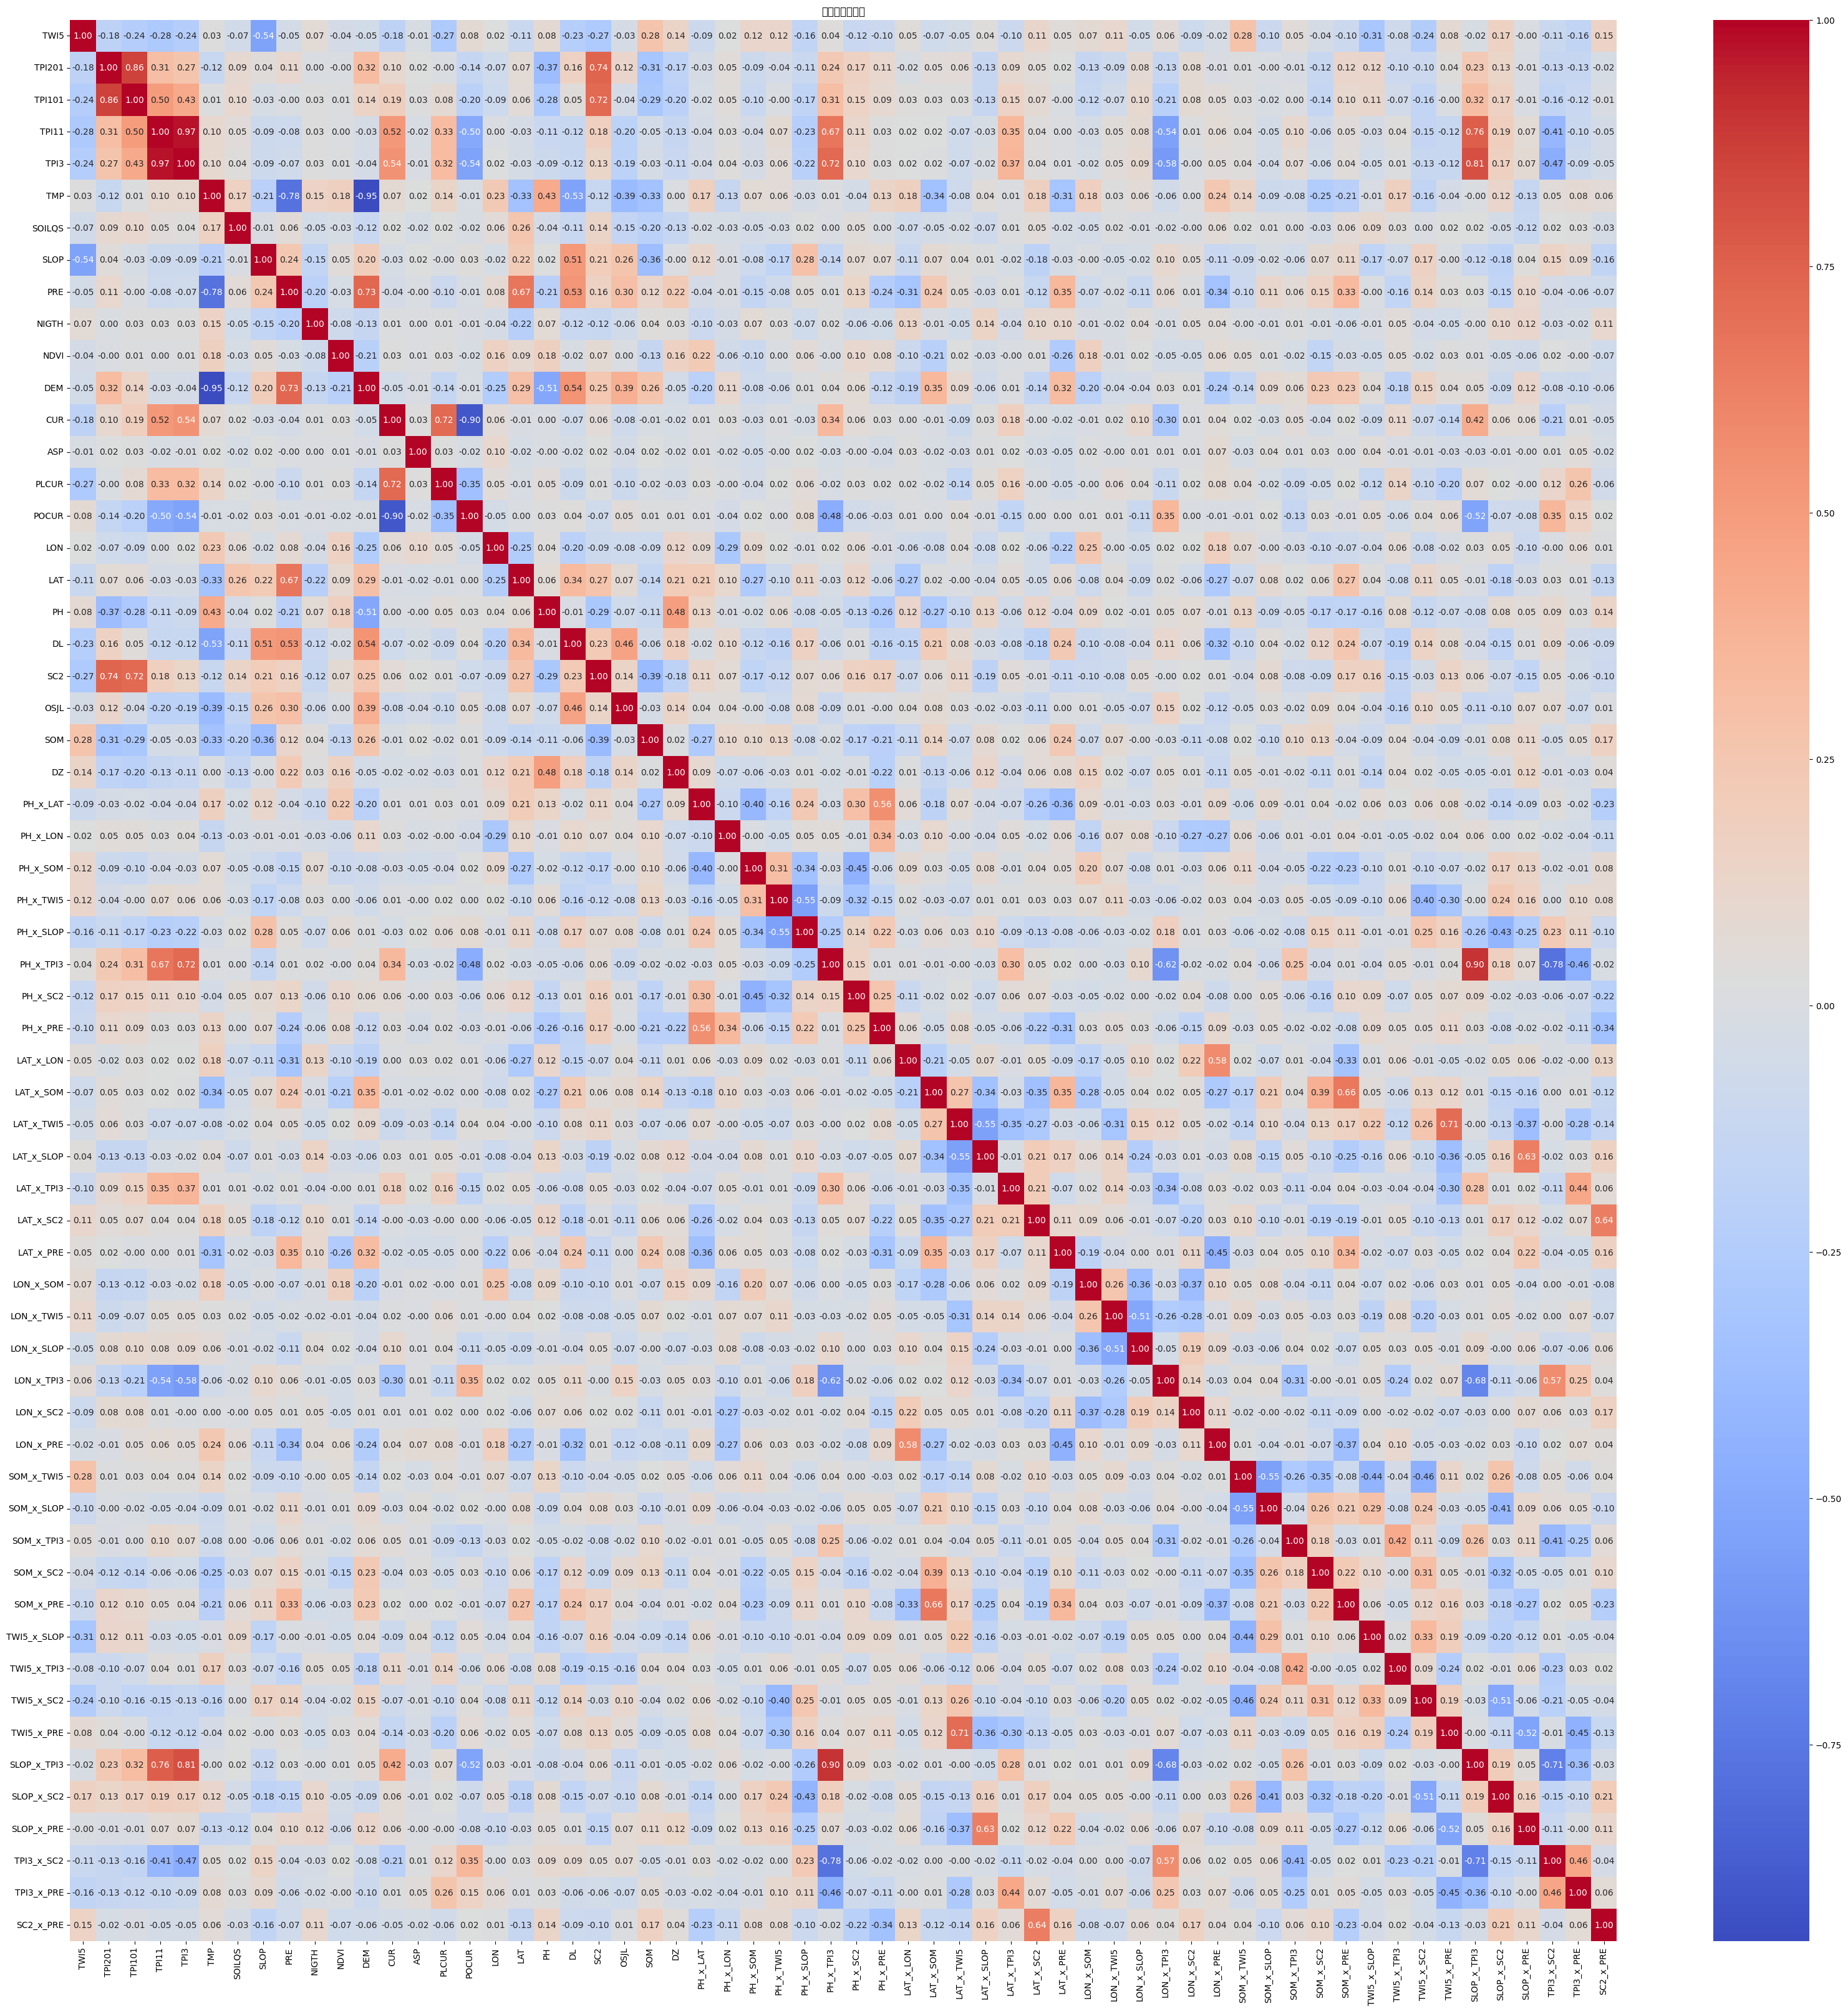

In [2]:
# 1. 特征重要性分析

# 使用随机森林分类器来评估特征的重要性
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
feature_importance = rf_classifier.feature_importances_

# 创建一个DataFrame来显示特征及其重要性
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# 根据重要性排序
features_df = features_df.sort_values(by='Importance', ascending=False)

# 作图展示特征的重要性
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('特征重要性')
plt.show()

# 2. 特征相关性分析

# 计算特征的相关性矩阵
correlation_matrix = X.corr()

# 作图展示特征的相关性
plt.figure(figsize=(40, 40))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('特征相关性矩阵')
plt.show()
